In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from MTGpred.utils.mtgjson import simplify_name, parse_mana_cost
import re
import torch
import pandas as pd

import os
import pandas as pd

from MTGpred.utils.mtgjson import load_cards_df
from sklearn.model_selection import train_test_split

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import wandb

BASE_PATH = "../../"

/data2/users/javierj/miniconda3/envs/mtg-preds/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class AllPickedCardsDataset(Dataset):
    def __init__(
        self,
        cards_df: pd.DataFrame,
        picked_cards: pd.DataFrame,
        model_name: str = "xlnet-base-cased",
        cased: bool = True,
        join_tokens: bool = True,
        max_length: int = 4096,
        truncation: bool = True,
        include_name: bool = True,
    ):
        """
        Dataset for decks classification

        Parameters
        ----------
        cards_df : pd.DataFrame
            Dataframe with all the cards
        picked_cards : pd.DataFrame
            Dataframe with all the picked cards
        model_name : str, optional
            Name of the transformer model, by default "xlnet-base-cased"
        cased : bool, optional
            Cased the card output or not, by default True
        join_tokens : bool, optional
            Join all texts and tokenize all or not, by default False
        max_length : int, optional
            Max length of the tokenizer, by default 256
        truncation : bool, optional
            Truncate the text or not, by default True
        """

        assert not join_tokens or (
            join_tokens and truncation
        ), "If join_tokens is True, truncation must be True"

        self.cards_df = cards_df
        self.data = picked_cards
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.cased = cased
        self.join_tokens = join_tokens
        self.max_length = max_length
        self.truncation = truncation
        self.include_name = include_name

    def __len__(self):
        return len(self.data)

    def preprocess_card(self, name: str):
        simplified_name = simplify_name(name)
        all_variations = []

        selected_card = self.cards_df[
            (self.cards_df["faceName"] == simplified_name)
            | (self.cards_df["name"] == simplified_name)
        ]
        if len(selected_card) == 0:
            print(
                f"WARNING: {name} cant be found in the database. Will be removed from the deck."
            )
            return []

        for index, variations in selected_card.iterrows():
            mana_cost = (
                parse_mana_cost(variations["manaCost"])
                if not pd.isna(variations["manaCost"])
                else ""
            )

            card_type = variations["type"]

            text = variations["text"] if not pd.isna(variations["text"]) else ""
            mana_in_text = re.findall(r"\{.*\}", text)
            for mana in mana_in_text:
                text = text.replace(mana, parse_mana_cost(mana))

            if self.include_name:
                input_text = ". ".join([name, mana_cost, card_type, text])
            else:
                input_text = ". ".join([mana_cost, card_type, text])

            if variations["power"] != np.nan or variations["toughness"] != np.nan:
                input_text += f" - {variations['power']} power, {variations['toughness']} toughness"

            if not self.cased:
                input_text = input_text.lower()

            all_variations.append(input_text)

        return all_variations

    def get_tokenized_text(self, picks_data):
        all_cards = []

        for card in picks_data:
            all_cards.extend(self.preprocess_card(card))

        if self.join_tokens:
            all_cards = self.tokenizer.sep_token.join(all_cards)

            tokenized_deck = self.tokenizer(
                all_cards,
                padding="max_length",
                max_length=self.max_length,
                truncation=self.truncation,
            )

            # tokens = self.tokenizer.tokenize(
            #    all_cards,
            # )

            # print(len(tokens), tokens)
        else:
            tokenized_deck = []
            for card in all_cards:
                tokenized_deck.append(
                    self.tokenizer(
                        card,
                        return_tensors="pt",
                        padding="max_length",
                        max_length=self.max_length,
                        truncation=self.truncation,
                    )
                )

        return tokenized_deck

    def __getitem__(self, idx):
        picks_data = self.data.iloc[idx]

        picks = self.get_tokenized_text(picks_data["picks"])

        if self.join_tokens:
            picks["labels"] = torch.tensor(picks_data["wins"])

            return picks
        else:
            return {
                "input": picks,
                "label": picks_data["wins"],
                "mask_length": len(picks),
            }


def get_drafted_data(data_folder: str, num_drafts: int = 10000):
    files = os.listdir(data_folder)
    total_drafts = 0
    drafts = []

    for f in files:
        df = pd.read_csv(os.path.join(data_folder, f))
        df = df[df["pick_number"] <= 8]
        groups = df.groupby("draft_id")

        for draft_id, group in groups:
            drafts.append(
                pd.DataFrame(
                    {
                        "picks": [list(group["pick"])],
                        "wins": group["event_match_wins"].iloc[0],
                    }
                )
            )

        total_drafts += len(df["draft_id"].unique())

        if total_drafts >= num_drafts:
            break

    return pd.concat(drafts)


df = get_drafted_data(f"{BASE_PATH}data/draft/draft_data/")

/data2/users/javierj/miniconda3/envs/mtg-preds/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f44fc5812b0>>
Traceback (most recent call last):
  File "/data2/users/javierj/miniconda3/envs/mtg-preds/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [4]:
def get_pool(group):
    pick = group.iloc[-1]["pick"]
    wins = group.iloc[-1]["event_match_wins"]
    pool = group.loc[:, group.columns.str.contains("pool")].iloc[-1]
    pool[f"pool_{pick}"] = pool[f"pool_{pick}"] + 1
    pool["wins"] = wins

    return pool


def get_drafted_matrix(data_folder: str, num_drafts: int = 5000):
    files = os.listdir(data_folder)
    total_drafts = 0
    Xs = []
    ys = []

    for f in files:
        df = pd.read_csv(os.path.join(data_folder, f))
        # df = df[df["pick_number"] <= 8]

        pools = df.groupby("draft_id").apply(get_pool).reset_index(drop=True)

        X = pools.drop(columns=["wins"])
        y = compute_y_std(X, pools["wins"])

        Xs.append(X)
        ys.append(y)

        total_drafts += len(df["draft_id"].unique())

        if total_drafts >= num_drafts:
            break

    X = np.concatenate(Xs)
    y = np.concatenate(ys)

    return X[:num_drafts], y[:num_drafts]


def compute_distances(matriz):
    matriz_np = np.array(matriz)
    expand_matriz = matriz_np[:, np.newaxis, :]
    minimo_comparado = np.minimum(expand_matriz, matriz_np[np.newaxis, :, :])
    sumas_minimas = minimo_comparado.sum(axis=2)
    np.fill_diagonal(sumas_minimas, 0)

    return sumas_minimas


def compute_y_std(X, y):
    distances = compute_distances(X)

    prob_wins = np.exp(distances) / np.sum(np.exp(distances), axis=0)
    y_std = (prob_wins * y.repeat(len(y)).values.reshape(-1, len(y))).sum(axis=0)

    return y_std


X, y = get_drafted_matrix(f"{BASE_PATH}data/draft/draft_data/")

print(X.shape)
y

(5000, 326)


array([3.63617062, 2.94910122, 4.21027067, ..., 3.2000842 , 3.48733912,
       0.04331379])

(array([  2.,   0.,   3.,   2.,   0.,   2.,   3.,   4.,   2.,   1.,   0.,
          4.,   4.,   7.,   3.,   7.,   7.,   9.,  13.,  20.,  14.,  19.,
         16.,  20.,  29.,  57.,  42.,  45.,  65.,  72.,  67.,  67.,  71.,
         69.,  63.,  79.,  77., 108.,  63.,  78.,  72.,  74.,  63.,  63.,
         36.,  43.,  30.,  39.,  36.,  17.,  30.,  29.,  34.,  18.,  14.,
         21.,  18.,  13.,  16.,  12.,   9.,   6.,  12.,   6.,   7.,   8.,
          3.,   4.,   4.,   5.,   5.,   3.,   1.,   3.,   4.,   2.,   4.,
          1.,   0.,   3.,   5.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   3.,   3.,   2.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.]),
 array([0.45842697, 0.52080269, 0.58317842, 0.64555414, 0.70792987,
        0.7703056 , 0.83268132, 0.89505705, 0.95743277, 1.0198085 ,
        1.08218423, 1.14455995, 1.20693568, 1.2693114 , 1.33168713,
        1.39406285, 1.45643858, 1.51881431, 1.58119003, 1.64356576,
        1.70594148, 1.76831721, 1.83069294, 1.

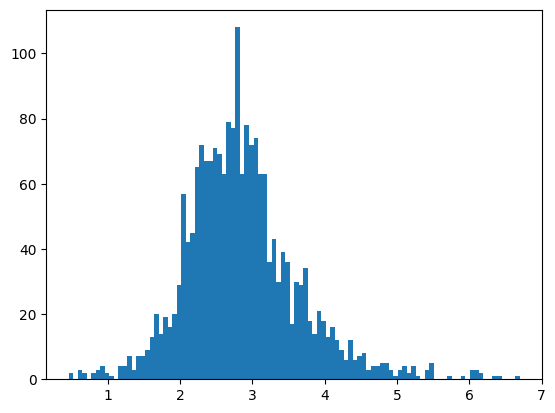

In [9]:
from matplotlib import pyplot as plt

plt.hist(np.random.choice(y, 2000), bins=100)

In [ ]:
def get_pool(group):
    pick = group.iloc[-1]["pick"]
    pool = group.loc[:, group.columns.str.contains("pool")].iloc[-1]
    pool[f"pool_{pick}"] = pool[f"pool_{pick}"] + 1

    return pool


df = pd.read_csv(
    "/data2/users/javierj/MTG_predictions/data/draft/draft_data/part_0.csv"
)
pools = df.groupby("draft_id").apply(get_pool).reset_index(drop=True)
pools.columns = pools.columns.str.replace("pool_", "")

pools

,A Killer Among Us,Absolving Lammasu,Aftermath Analyst,Agency Coroner,Agency Outfitter,"Agrus Kos, Spirit of Justice",Airtight Alibi,Alley Assailant,"Alquist Proft, Master Sleuth",Analyze the Pollen,...,Vengeful Tracker,Victimize,Vitu-Ghazi Inspector,Warleader's Call,Wispdrinker Vampire,Wojek Investigator,Worldsoul's Rage,Worldspine Wurm,Wrench,"Yarus, Roar of the Old Gods"
0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,1
2,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1338,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1340,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

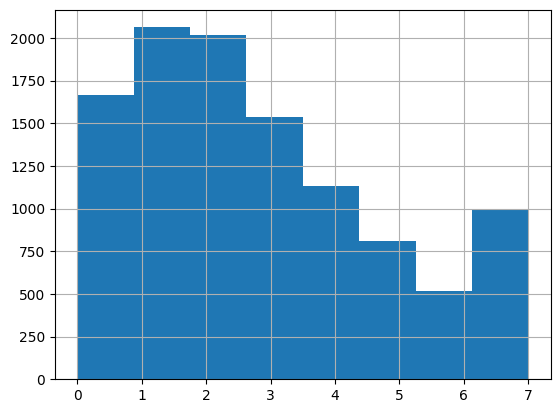

In [ ]:
df["wins"].hist(bins=8)

<Axes: >

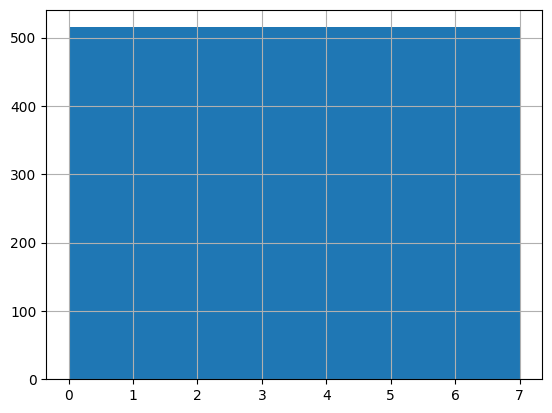

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(df[["picks"]], df["wins"])
df_resampled = pd.DataFrame({"picks": X_resampled["picks"], "wins": y_resampled})

df_resampled["wins"].hist(bins=8)

In [ ]:
from transformers import TrainerCallback, TrainerControl, TrainerState


class WandbLoggingCallback(TrainerCallback):
    "Callback that logs the predictions to wandb at each logging step."

    def __init__(self, sample_size=100):
        self.sample_size = sample_size

    def on_log(
        self, args, state: TrainerState, control: TrainerControl, logs=None, **kwargs
    ):
        trainer = kwargs.get("trainer")
        # Get a random subset of the training dataset
        subset_indices = np.random.choice(
            len(trainer.train_dataset), self.sample_size, replace=False
        )
        subset = trainer.train_dataset.select(subset_indices)

        # Make predictions on the subset
        predictions = trainer.predict(subset)
        # Assuming softmax over logits for classification tasks
        probs = predictions.predictions.softmax(-1)
        preds = probs.argmax(-1)

        # Log to wandb
        wandb.log({"sample_predictions": preds}, step=state.global_step)

In [ ]:
cards_df = load_cards_df(data_path=f"{BASE_PATH}data/AtomicCards.json")

BASE_MODEL = f"{BASE_PATH}/models/longformer_v2"

train_cards, test_cards = train_test_split(df_resampled, test_size=0.1, random_state=42)

train_dataset = AllPickedCardsDataset(
    cards_df, train_cards, model_name="allenai/longformer-base-4096", cased=False
)
test_dataset = AllPickedCardsDataset(
    cards_df, test_cards, model_name="allenai/longformer-base-4096", cased=False
)

accuracy = evaluate.load("accuracy")

# Cargar métricas
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calcular métricas
    accuracy_result = accuracy.compute(predictions=predictions, references=labels)
    f1_result = f1.compute(predictions=predictions, references=labels, average="macro")
    precision_result = precision.compute(
        predictions=predictions, references=labels, average="macro"
    )
    recall_result = recall.compute(
        predictions=predictions, references=labels, average="macro"
    )

    wandb.log(
        {
            "confusion_matrix": wandb.plot.confusion_matrix(
                probs=None, y_true=labels, preds=predictions
            )
        }
    )

    return {
        "accuracy": accuracy_result["accuracy"],
        "f1": f1_result["f1"],
        "precision": precision_result["precision"],
        "recall": recall_result["recall"],
    }


model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL,
    num_labels=df["wins"].nunique(),
    hidden_dropout_prob=0.14,
    attention_probs_dropout_prob=0.14,
    ignore_mismatched_sizes=True,
)

training_args = TrainingArguments(
    output_dir=f"{BASE_PATH}/models/draft-longformer",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=16,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    gradient_checkpointing=True,
    logging_steps=1,
    lr_scheduler_type="constant_with_warmup",
    warmup_ratio=0.1,
    disable_tqdm=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    # callbacks=[WandbLoggingCallback(sample_size=100)],
)

wandb.init(project="MTGpred-Drafts", entity="javier-jimenez99")
trainer.train()
wandb.finish()

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at ../..//models/longformer_v2 and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: javier-jimenez99. Use `wandb login --relogin` to force relogin


Initializing global attention on CLS token...
/data2/users/javierj/miniconda3/envs/mtg-preds/lib/python3.8/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
